# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [38]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import os
import csv

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [39]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

589

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [40]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

city_name = []
lat = []
lng = []
temp_max = []
humidity = []
clouds = []
wind = []
country = []
date = []

count = 0
total = 1
setno = 1
print(f'Beginning Data Retrieval\n-----------------------------')
for city in cities:

    response = requests.get(query_url + city).json()

    try:
        city_name.append(response['name'])
        lat.append(response['coord']['lat'])
        lng.append(response['coord']['lon'])
        temp_max.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        clouds.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])

        print(f"Processing Record {count} of Set {setno} | {total} | {city}")
        count += 1
        total += 1
        if count % 50 == 0:
            setno += 1
            count = 0
    # Handle exceptions
    except:
        # Append null values
        print("City not found. Skipping...")
print(f'-----------------------------\nTotal Records Processed: {total}\n-----------------------------\n')
print(f'-----------------------------\nData Retrieval Complete\n-----------------------------\n')


Beginning Data Retrieval
-----------------------------
Processing Record 0 of Set 1 | 1 | ushuaia
Processing Record 1 of Set 1 | 2 | norman wells
City not found. Skipping...
City not found. Skipping...
Processing Record 2 of Set 1 | 3 | murdochville
Processing Record 3 of Set 1 | 4 | hermanus
Processing Record 4 of Set 1 | 5 | kapaa
Processing Record 5 of Set 1 | 6 | busselton
Processing Record 6 of Set 1 | 7 | shahrud
Processing Record 7 of Set 1 | 8 | fortuna
Processing Record 8 of Set 1 | 9 | sao joao da barra
Processing Record 9 of Set 1 | 10 | hobart
Processing Record 10 of Set 1 | 11 | turukhansk
Processing Record 11 of Set 1 | 12 | rikitea
Processing Record 12 of Set 1 | 13 | lompoc
Processing Record 13 of Set 1 | 14 | atuona
City not found. Skipping...
City not found. Skipping...
City not found. Skipping...
Processing Record 14 of Set 1 | 15 | iqaluit
Processing Record 15 of Set 1 | 16 | port hardy
Processing Record 16 of Set 1 | 17 | nuevo progreso
Processing Record 17 of Set 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [41]:
# create dataframe
cities_dict = {
            'City': city_name,
            'Lat': lat,
            'Lng': lng,
            'Max Temp': temp_max,
            'Humidity': humidity,
            'Cloudiness': clouds,
            'Wind Speed': wind,
            'Country': country,
            'Date': date,
}
show_dict = pd.DataFrame(cities_dict)
show_dict.head(20)

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Ushuaia,-54.8000,-68.3000,55.02,53,75,6.91,AR,1628178005
1,Norman Wells,65.2820,-126.8329,57.24,77,40,8.05,CA,1628178372
2,Murdochville,48.9583,-65.5006,63.48,51,52,11.07,CA,1628178460
3,Hermanus,-34.4187,19.2345,58.06,82,42,13.18,ZA,1628178300
4,Kapaa,22.0752,-159.3190,79.12,78,40,4.00,US,1628178296
5,Busselton,-33.6500,115.3333,46.09,84,0,6.60,AU,1628178313
6,Shahrud,36.4182,54.9763,76.98,34,16,12.33,IR,1628178461
7,Fortuna,40.5982,-124.1573,57.92,75,90,4.61,US,1628178390
8,São João da Barra,-21.6403,-41.0511,75.29,68,45,10.58,BR,1628178461
9,Hobart,-42.8794,147.3294,53.46,65,99,3.00,AU,1628178077


In [42]:
cs = show_dict[['Lat', 'Lng', 'Max Temp', 'Humidity', 'Cloudiness','Wind Speed', 'Date']]
quartiles = cs.quantile([0.25, 0.5,0.75])
cities_stats = cs.aggregate(['count','mean','std', 'min','max'])
cities_stats = cities_stats.append(quartiles)
cities_stats.index = ['count', 'mean', 'std', 'min', '0.25', '0.5', '0.75', 'max']
cities_stats = cities_stats.rename(index={'0.25': '25%', '0.5': '50%', '0.75': '75%'})
cities_stats

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,5.400000e+02
mean,21.856390,20.207078,71.413833,69.088889,56.859259,7.782463,1.628178e+09
std,33.556144,89.343153,15.069522,21.793249,36.834769,5.270406,1.223436e+02
min,-54.800000,-175.200000,32.320000,9.000000,0.000000,0.000000,1.628178e+09
25%,78.218600,179.316700,109.810000,100.000000,100.000000,34.520000,1.628179e+09
50%,-4.314875,-57.576450,60.862500,57.750000,20.000000,3.875000,1.628178e+09
75%,26.821350,23.110750,72.610000,75.000000,69.000000,6.835000,1.628179e+09
max,50.677475,96.425025,81.555000,86.000000,90.000000,10.592500,1.628179e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [71]:
over_hun = show_dict[show_dict['Humidity'] > 100]
print(f'Amount of cities with humidity over 100%: {len(over_hun)}')

show_dict = show_dict.drop(over_hun.index,inplace=False)
show_dict

Amount of cities with humidity over 100%: 0


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Ushuaia,-54.8000,-68.3000,55.02,53,75,6.91,AR,1628178005
1,Norman Wells,65.2820,-126.8329,57.24,77,40,8.05,CA,1628178372
2,Murdochville,48.9583,-65.5006,63.48,51,52,11.07,CA,1628178460
3,Hermanus,-34.4187,19.2345,58.06,82,42,13.18,ZA,1628178300
4,Kapaa,22.0752,-159.3190,79.12,78,40,4.00,US,1628178296
...,...,...,...,...,...,...,...,...,...
535,Muros,42.7762,-9.0603,72.09,71,39,8.32,ES,1628178361
536,Yumen,40.2833,97.2000,79.61,14,96,9.40,CN,1628178386
537,Rāvar,31.2656,56.8055,89.02,13,4,4.65,IR,1628178640
538,Pisco,-13.7000,-76.2167,66.25,68,20,6.91,PE,1628178415


In [44]:
qts = show_dict['Humidity'].quantile([0.25, 0.5,0.75])
# set lower quartile
lowerq = qts[0.25]
# set upper quartile
upperq = qts[0.75]
# calculate interquartile range
iqr = upperq-lowerq
# calculate the lower bound
lower_bound = lowerq - (1.5*iqr)
# calculate the upper bound
upper_bound = upperq + (1.5*iqr)

outliers = show_dict[(show_dict['Humidity'] < lower_bound) | (show_dict['Humidity'] > upper_bound)]
outliers_list = outliers.index
outliers_df = show_dict.iloc[outliers_list]
outliers_df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
24,Diego de Almagro,-26.3667,-70.0500,73.76,12,0,4.16,CL,1628178466
70,Atar,20.5169,-13.0499,108.99,11,0,13.04,MR,1628178346
143,Sakakah,29.9697,40.2064,107.17,10,30,10.45,SA,1628178501
297,Adrar,20.5022,-10.0711,109.81,9,0,18.81,MR,1628178552
316,Bilma,18.6853,12.9164,105.87,13,4,6.69,NE,1628178557
327,Aswān,24.0934,32.9070,107.02,10,28,9.91,EG,1628178561
330,Buraidah,26.3260,43.9750,106.25,12,93,6.24,SA,1628178363
358,Jalu,29.0331,21.5482,107.76,10,0,14.50,LY,1628178571
394,Kikwit,-5.0410,18.8162,99.25,13,0,1.83,CD,1628178583
406,Denizli Province,37.8402,29.0698,101.25,12,0,9.24,TR,1628178588


In [62]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

clean_city_data = show_dict.drop(outliers_df.index,inplace=False)

# # export output to txt file
# #
clean_city_data.to_csv(output_data_file, index=False, encoding="utf-8")
clean_city_data


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Ushuaia,-54.8000,-68.3000,55.02,53,75,6.91,AR,1628178005
1,Norman Wells,65.2820,-126.8329,57.24,77,40,8.05,CA,1628178372
2,Murdochville,48.9583,-65.5006,63.48,51,52,11.07,CA,1628178460
3,Hermanus,-34.4187,19.2345,58.06,82,42,13.18,ZA,1628178300
4,Kapaa,22.0752,-159.3190,79.12,78,40,4.00,US,1628178296
...,...,...,...,...,...,...,...,...,...
533,Marsá Maţrūḩ,31.3525,27.2453,87.46,57,0,16.75,EG,1628178639
534,Bima,-8.4667,118.7167,73.17,92,94,3.67,ID,1628178639
535,Muros,42.7762,-9.0603,72.09,71,39,8.32,ES,1628178361
538,Pisco,-13.7000,-76.2167,66.25,68,20,6.91,PE,1628178415


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

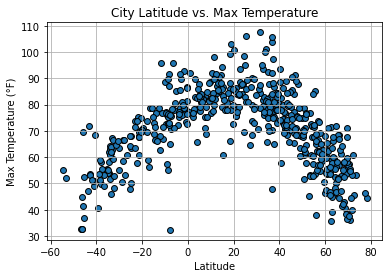

In [46]:
clean_city_data.plot(kind='scatter', x='Lat', y='Max Temp',grid=True, title="City Latitude vs. Max Temperature",edgecolors='black', s=35)
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
plt.savefig("../output_data/City Latitude vs. Max Temperature.png")
plt.show()

## Latitude vs. Humidity Plot

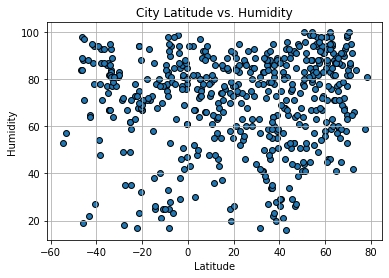

In [47]:
clean_city_data.plot(kind='scatter', x='Lat', y='Humidity',grid=True, title="City Latitude vs. Humidity",edgecolors='black',s=35)
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.savefig("../output_data/City Latitude vs. Humidity.png")
plt.show()

## Latitude vs. Cloudiness Plot

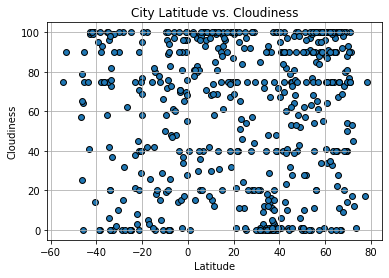

In [48]:
clean_city_data.plot(kind='scatter', x='Lat', y='Cloudiness',grid=True, title="City Latitude vs. Cloudiness",edgecolors='black',s=35)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.savefig("../output_data/City Latitude vs. Cloudiness.png")
plt.show()

## Latitude vs. Wind Speed Plot

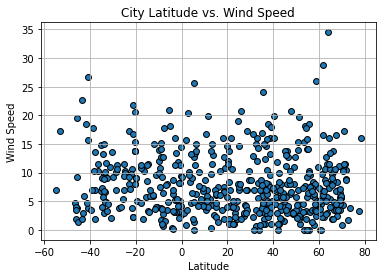

In [49]:
clean_city_data.plot(kind='scatter', x='Lat', y='Wind Speed',grid=True, title="City Latitude vs. Wind Speed",edgecolors='black',s=35)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.savefig("../output_data/City Latitude vs. Wind Speed.png")
plt.show()

## Linear Regression

In [50]:
nh = clean_city_data[clean_city_data['Lat'] >= 0]
sh = clean_city_data[clean_city_data['Lat'] < 0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.7255026789366209


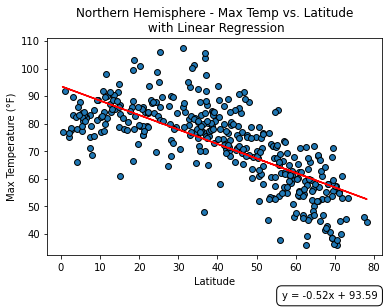

In [51]:
# set x and y values
x_values = nh['Lat']
y_values = nh['Max Temp']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
plt.title('Northern Hemisphere - Max Temp vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Northern Hemisphere - Max Temp vs. Latitude Linear Regression.png")
plt.show()


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.7735294563817562


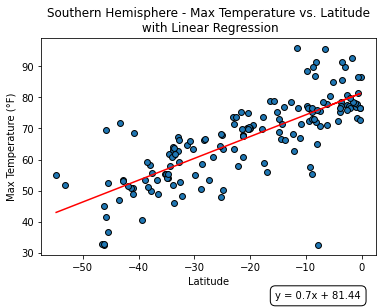

In [52]:
# set x and y values
x_values = sh['Lat']
y_values = sh['Max Temp']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
plt.title('Southern Hemisphere - Max Temperature vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Southern Hemisphere - Max Temperature vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.13313657963639317


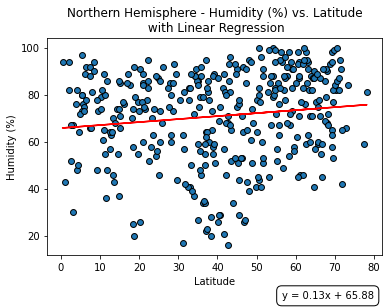

In [53]:
# set x and y values
x_values = nh['Lat']
y_values = nh['Humidity']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Northern Hemisphere - Humidity (%) vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: -0.09318195610990175


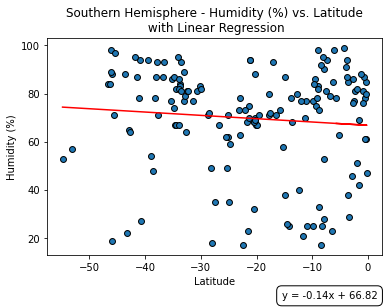

In [54]:
# set x and y values
x_values = sh['Lat']
y_values = sh['Humidity']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Southern Hemisphere - Humidity (%) vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: -0.0026623013316250557


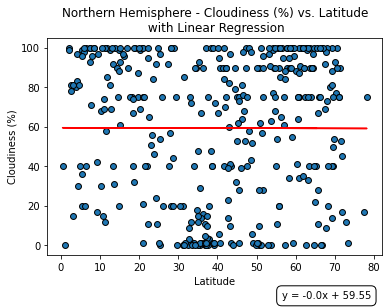

In [55]:
# set x and y values
x_values = nh['Lat']
y_values = nh['Cloudiness']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Northern Hemisphere - Cloudiness (%) vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: -0.03893183490316437


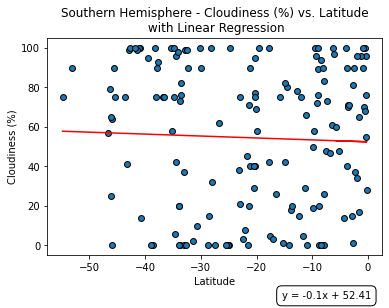

In [56]:
# set x and y values
x_values = sh['Lat']
y_values = sh['Cloudiness']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Southern Hemisphere - Cloudiness (%) vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression.png")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.010622672621338728


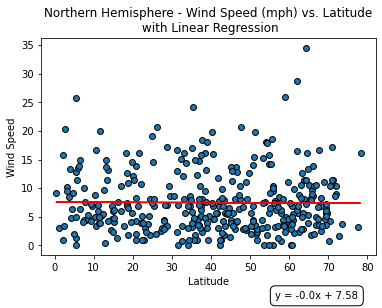

In [57]:
# set x and y values
x_values = nh['Lat']
y_values = nh['Wind Speed']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.title('Northern Hemisphere - Wind Speed (mph) vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression.png")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.10709088475295088


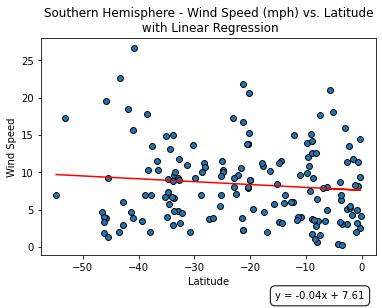

In [58]:
# set x and y values
x_values = sh['Lat']
y_values = sh['Wind Speed']
# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# variable for calculation of regression line
regress_values = x_values * slope + intercept
# variable for equation of slope intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-value is: {rvalue}")
# scatter plot of weight and average tumor volume
plt.scatter(x_values,y_values, edgecolors='black',s=35)
# plot the line of the slope intercept equation
plt.plot(x_values,regress_values,"red")
# style the box for the equation
le_bbox = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=1)
# add the equation to the plot
plt.annotate(line_eq,
            xy=(0, 1.5),
            xycoords='axes fraction',
            xytext=(0.7, -.2),
            bbox=le_bbox)
# set the title and axis labels
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.title('Southern Hemisphere - Wind Speed (mph) vs. Latitude\n with Linear Regression')
plt.savefig("../output_data/Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression.png")
plt.show()